# 階層分群法 觀察 : 使用 2D 樣板資料集

# [教學目標]
- 將階層式聚類套用在 2D 樣板資料上, 來觀察幾種不同參數的結果有何不同 
- 因為非監督模型的效果, 較難以簡單的範例看出來  
  所以後續非監督偶數日提供的範例與作業, 主要目的在於觀察非監督模型的效果,  
  同學只要能感受到模型效果即可, 不用執著於搞懂程式的每一個部分

# [範例重點]
- 以幾種 2D 樣板資料, 觀察階層式聚類在 "linkage參數" 有所不同時, 分群的效果如何變化 (In[3], Out[3])

In [1]:
# 載入套件
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

(nx2) * (2x2) = nx2 <br>
x*0.6 + y*(-0.4) = new_x <br> 
x*(-0.4) + y*0.8 = new_y <br>

原第一象限(10,10) = (2, 4) 往左下拉 <br>
原第二象限(-10,10) = (-10,12) 往左上拉 <br>
原第三象限(-10,-10)  = (-2,-4) 往右上拉 <br>
原第四象限(10,-10)  = (10,-12) 往右下拉 <br>

In [2]:
# 設定 2D 樣板資料
n_samples = 1500
random_state = 100

# 生成 同心圓 資料點
#factor 圈內圈外樣本比例 noise雜訊比例
#回傳資料將是(n_samples,2) 兩個特徵x,y座標
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)

# 生成 斜向三群 資料點 (使用轉換矩陣)
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# 生成 稀疏三群 資料點
varied = datasets.make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state)

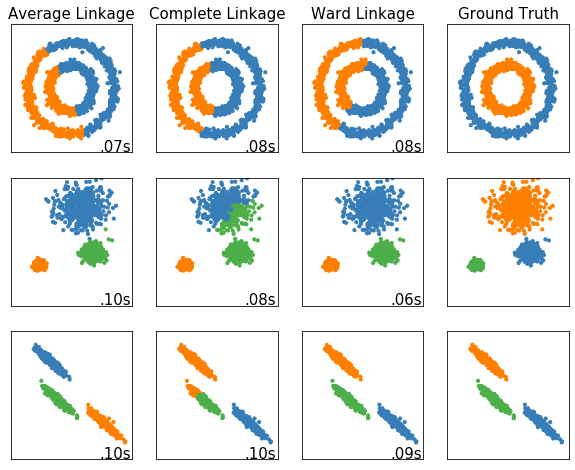

In [3]:
# 設定群集與繪圖參數
plt.figure(figsize=(10, 8))
plot_num = 1
default_base = {'n_neighbors': 10, 'n_clusters': 3}
datasets = [(noisy_circles, {'n_clusters': 2}), (varied, {'n_neighbors': 2}), (aniso, {'n_neighbors': 2})]

# 執行各種樣板資料的繪圖迴圈
# circle更新 clusters 3 -> 2
# 稀疏&斜向更新 n_neighbors 10 -> 2 階層分群沒有n_neighbors無意義參數
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # 複製參數與標準化
    params = default_base.copy()
    params.update(algo_params)    
    X, y = dataset
    X = StandardScaler().fit_transform(X)

    # 設定三種不同參數的 Hierarchical clustering
    ward = cluster.AgglomerativeClustering(n_clusters=params['n_clusters'], linkage="ward")
    complete = cluster.AgglomerativeClustering(n_clusters=params['n_clusters'], linkage="complete")
    average = cluster.AgglomerativeClustering(n_clusters=params['n_clusters'], linkage="average")
    clustering_algorithms = (
        ('Average Linkage', average),
        ('Complete Linkage', complete),
        ('Ward Linkage', ward))

    # 繪製三種圖形
    for name, algorithm in clustering_algorithms:
        # t0 / t1 : 紀錄時間差
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        
        #hasattr 判斷algorithm是否有 labels_這個屬性
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms)+1, plot_num)
        if i_dataset == 0:
            plt.title(name, size=15)

        #islice(要跑的內容, start, stop, step)
        #cycle類似for while loop循環進行 #dede00 -> #377eb8...
        #預測出幾種類別 就採用幾種類別顏色
        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        
        #lstrip捨去字串最左邊數來的0 直到遇到非0
        #plt.gca()取得當前子圖
        #transform代表以當前子圖的坐標軸進行位置設定 左下為(0,0) 右上為(1,1) 所以x=.99 , y=.01 右下角
        #horizontalalignment 代表文字開頭是設定xy的左還是右或是中間
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'), transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1
        
    plt.subplot(len(datasets), len(clustering_algorithms)+1, plot_num)
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y])
    
    if i_dataset == 0:
        plt.title("Ground Truth", size=15)
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plot_num += 1
    
plt.show()

# 觀察結果
* 同心圓 : 三者效果中 Complete 的效果似乎是最差
* 三群 : Average 與 Ward 效果都還不錯
* 斜三群 : 三者效果也是以 Complete 較差
* 同學可以試著替換不同的 random_state 觀察, 會有不同的結果

# [作業目標]
- 將階層式聚類套用在 2D 樣板資料上, 來觀察幾種不同參數的結果有何不同

# [作業重點]
- 以幾種 2D 樣板資料, 觀察階層式聚類在 "linkage參數" 有所不同時, 分群的效果如何變化 (In[6], Out[6])# [作業重點]

In [4]:
# 載入套件
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

In [5]:
# 設定 2D 樣板資料
n_samples = 1500
random_state = 100

# 生成 雙半月 資料點
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)

# 生成 緊密三群 資料點
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)

# 生成 2維均勻分布 資料點
no_structure = np.random.rand(n_samples, 2), np.zeros((n_samples,), dtype=int)

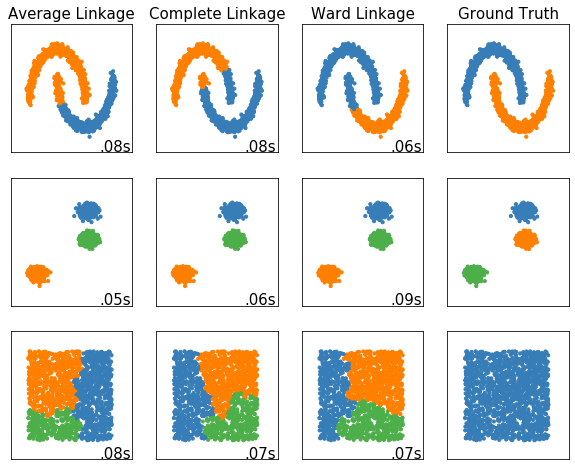

In [6]:
# 執行各種樣板資料的繪圖迴圈

# 設定群集與繪圖參數
plt.figure(figsize=(10, 8))
plot_num = 1
default_base = {'n_neighbors': 10, 'n_clusters': 3}
datasets = [(noisy_moons, {'n_clusters': 2}), (blobs, {}), (no_structure, {})]

# 執行各種樣板資料的繪圖迴圈
# circle更新 clusters 3 -> 2
# 稀疏&斜向更新 n_neighbors 10 -> 2 階層分群沒有n_neighbors無意義參數
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # 複製參數與標準化
    params = default_base.copy()
    params.update(algo_params)    
    X, y = dataset
    X = StandardScaler().fit_transform(X)

    # 設定三種不同參數的 Hierarchical clustering
    ward = cluster.AgglomerativeClustering(n_clusters=params['n_clusters'], linkage="ward")
    complete = cluster.AgglomerativeClustering(n_clusters=params['n_clusters'], linkage="complete")
    average = cluster.AgglomerativeClustering(n_clusters=params['n_clusters'], linkage="average")
    clustering_algorithms = (
        ('Average Linkage', average),
        ('Complete Linkage', complete),
        ('Ward Linkage', ward))

    # 繪製三種圖形
    for name, algorithm in clustering_algorithms:
        # t0 / t1 : 紀錄時間差
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        
        #hasattr 判斷algorithm是否有 labels_這個屬性
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms)+1, plot_num)
        if i_dataset == 0:
            plt.title(name, size=15)

        #islice(要跑的內容, start, stop, step)
        #cycle類似for while loop循環進行 #dede00 -> #377eb8...
        #預測出幾種類別 就採用幾種類別顏色
        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        
        #lstrip捨去字串最左邊數來的0 直到遇到非0
        #plt.gca()取得當前子圖
        #transform代表以當前子圖的坐標軸進行位置設定 左下為(0,0) 右上為(1,1) 所以x=.99 , y=.01 右下角
        #horizontalalignment 代表文字開頭是設定xy的左還是右或是中間
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'), transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1
        
    plt.subplot(len(datasets), len(clustering_algorithms)+1, plot_num)
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y])
    
    if i_dataset == 0:
        plt.title("Ground Truth", size=15)
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plot_num += 1
    
plt.show()

# 觀察結果
* 雙半月的結果Average 與 Ward相似  Complete的方法明顯與兩者不同
* 緊密三群的結果相同(random_state=8)